In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [20]:
print(customers.columns)
print(transactions.columns)

Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate'], dtype='object')
Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price'],
      dtype='object')


In [33]:
customers.isnull().sum()

,0
CustomerID,0
CustomerName,0
Region,0
SignupDate,0


In [34]:
transactions.isnull().sum()

,0
TransactionID,0
CustomerID,0
ProductID,0
TransactionDate,0
Quantity,0
TotalValue,0
Price,0


Transform SignupDate into datetime format for efficient processing


In [21]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])

In [22]:
temp = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'Quantity': 'sum',
}).reset_index()

In [23]:
temp.rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'NumTransactions',
    'Quantity': 'TotalQuantity'
}, inplace = True)

In [24]:
merged_data = customers.merge(temp, on='CustomerID', how='left')
merged_data.head()

,CustomerID,CustomerName,Region,SignupDate,TotalSpending,NumTransactions,TotalQuantity
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5.0,12.0
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4.0,10.0
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4.0,14.0
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8.0,23.0
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3.0,7.0


In [35]:
merged_data.isnull().sum()

,0
CustomerID,0
CustomerName,0
Region,0
SignupDate,0
TotalSpending,1
NumTransactions,1
TotalQuantity,1
DaysSinceSignup,0


In [36]:
merged_data.fillna({'TotalSpending': 0, 'NumTransactions': 0, 'TotalQuantity': 0}, inplace=True)

# Feature Engineering

In [37]:
merged_data['DaysSinceSignup'] = (pd.to_datetime('2025-01-01') - merged_data['SignupDate']).dt.days

In [38]:
encoder = LabelEncoder()
merged_data['Region'] = encoder.fit_transform(merged_data['Region'])

In [39]:
features = ['TotalSpending', 'NumTransactions', 'TotalQuantity', 'DaysSinceSignup', 'Region']
X = merged_data[features]

In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Clustering

In [42]:
scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    db_index = davies_bouldin_score(X_scaled, clusters)
    scores.append((k, db_index))
    print(f"Number of Clusters: {k} | DB Index: {db_index}")

best_k = min(scores, key=lambda x: x[1])[0]
print(f"\nOptimal Number of Clusters Based on DB Index: {best_k}")

kmeans = KMeans(n_clusters=best_k, random_state=42)
merged_data['Cluster'] = kmeans.fit_predict(X_scaled)

Number of Clusters: 2 | DB Index: 1.2785450609968063
Number of Clusters: 3 | DB Index: 1.4183814971353168
Number of Clusters: 4 | DB Index: 1.2792462154237905
Number of Clusters: 5 | DB Index: 1.2168644246987452
Number of Clusters: 6 | DB Index: 1.1777050211933284
Number of Clusters: 7 | DB Index: 1.2508076110294066
Number of Clusters: 8 | DB Index: 1.215626053511862
Number of Clusters: 9 | DB Index: 1.1917348949648376
Number of Clusters: 10 | DB Index: 1.174698732533864

Optimal Number of Clusters Based on DB Index: 10


# Vizualization

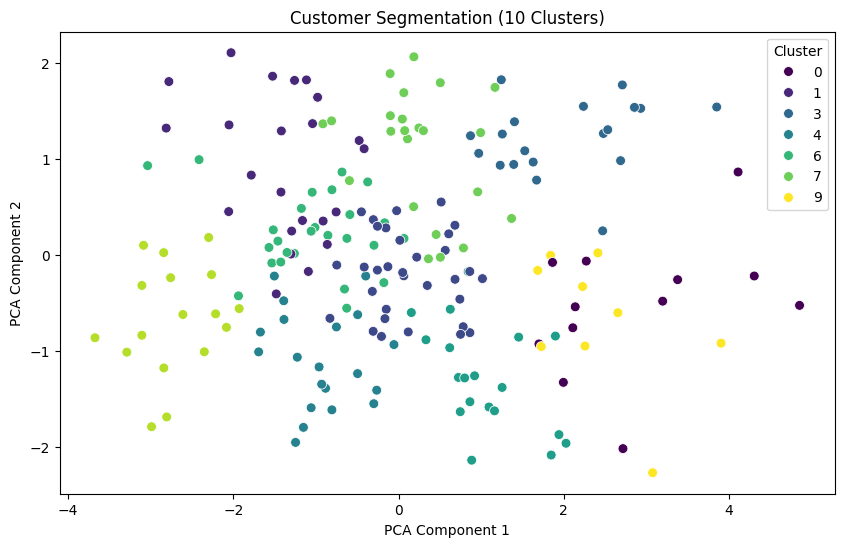

In [45]:
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

merged_data['PCA1'] = X_2d[:, 0]
merged_data['PCA2'] = X_2d[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=50)

plt.title(f'Customer Segmentation ({best_k} Clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Final

In [47]:
cluster_summary = merged_data.groupby('Cluster').agg({
    'TotalSpending': ['mean', 'median'],
    'NumTransactions': ['mean', 'median'],
    'TotalQuantity': ['mean', 'median'],
    'DaysSinceSignup': ['mean', 'median'],
    'CustomerID': 'count'  # Cluster size
}).rename(columns={'CustomerID': 'ClusterSize'})

cluster_summary.reset_index()

Cluster TotalSpending           NumTransactions        TotalQuantity         \
                   mean    median            mean median          mean median   
0       0   6337.408333  5828.505        8.833333    8.0     23.750000   23.5   
1       1   1914.283913  1959.510        3.086957    3.0      7.304348    8.0   
2       2   3384.881563  3340.075        5.468750    5.0     13.031250   12.5   
3       3   5636.996842  5457.790        6.947368    7.0     19.947368   20.0   
4       4   2534.385500  2563.510        4.150000    4.0      9.300000    9.0   
5       5   4820.105263  4758.600        6.315789    6.0     17.052632   16.0   
6       6   2242.103846  2162.040        3.615385    3.5      9.230769    9.5   
7       7   3625.947826  3434.770        5.391304    5.0     12.652174   12.0   
8       8    816.184118   922.410        1.411765    1.0      3.176471    3.0   
9       9   6295.848889  6149.780        7.888889    7.0     21.444444   21.0   

  DaysSinceSignup        ClusterSize  
             mean median       count  
0      717.166667  698.5          12  
1      580.913043  630.0          23  
2      234.156250  255.0          32  
3      809.105263  815.0          19  
4      291.850000  273.0          20  
5      280.631579  293.0          19  
6      861.115385  863.5          26  
7      906.608696  961.0          23  
8      300.823529  331.0          17  
9      219.111111  227.0           9

In [48]:
temp.to_csv('Rishav_Jain_Clustering.csv', index=False)
print("Clustering results saved to 'Rishav_Jain_Clustering.csv'")

Clustering results saved to 'Rishav_Jain_Clustering.csv'
